In [28]:
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from river import linear_model, preprocessing, compose, metrics

In [30]:
# --- Step 1: Generate synthetic data with multiple IDs ---
def generate_data_with_ids(n_days=30, ids=('A', 'B', 'C')):
    data = []
    base_time = datetime(2025, 3, 1)
    for item_id in ids:
        for day in range(n_days):
            for hour in range(24):
                ts = base_time + timedelta(days=day, hours=hour)

                # Simulate different patterns
                if item_id == 'A':
                    clicks = max(0, int(20 + 30 * random.random() - abs(hour - 20)*4 + random.gauss(0, 2)))
                elif item_id == 'B':
                    clicks = max(0, int(10 + 10 * random.random() - abs(hour - 14)*2 + random.gauss(0, 1)))
                else:
                    clicks = max(0, int(5 + 5 * random.random() + random.gauss(0, 1)))

                data.append((item_id, ts, clicks))
    return data

data = generate_data_with_ids()

In [32]:
# --- Step 2: Feature extractor with ID ---
def extract_features(item_id: str, ts: datetime):
    return {
        'item_id': item_id,
        'hour': ts.hour,
        'day_of_week': ts.weekday(),
        'is_weekend': int(ts.weekday() >= 5)
    }

In [34]:
# --- Step 3: Setup model (handles categorical variables too) ---
model_template = compose.Pipeline(
    preprocessing.OneHotEncoder(),
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)

mae = metrics.MAE()
y_true, y_pred = [], []

In [36]:
from collections import defaultdict
from river import linear_model, metrics, preprocessing

# Dictionary to hold models, metrics, and predictions
models = defaultdict(lambda: model_template.clone())
maes = defaultdict(lambda: metrics.MAE())
predictions = defaultdict(list)

# Split data per ID
for item_id in set(x[0] for x in data):
    item_data = [(i, ts, y) for (i, ts, y) in data if i == item_id]

    for _, ts, y in item_data:
        x = extract_features(item_id, ts)
        y_hat = models[item_id].predict_one(x) or 0
        models[item_id].learn_one(x, y)
        maes[item_id].update(y, y_hat)
        predictions[item_id].append((ts, y, y_hat))

# Print MAE per ID
for item_id, metric in maes.items():
    print(f"MAE for {item_id}: {metric.get():.2f}")

MAE for A: 5.18
MAE for B: 2.30
MAE for C: 1.95


In [44]:
# --- Step 5: Plot example for a given item_id only ---
def plot_daily(target_id):
    if target_id not in predictions:
        print(f"No predictions found for ID {target_id}")
        return

    # Unpack predictions
    id_timestamps, id_true, id_pred = zip(*predictions[target_id])

    plt.figure(figsize=(14, 5))
    plt.plot(id_timestamps, id_true, label=f'True Clicks ({target_id})', alpha=0.6)
    plt.plot(id_timestamps, id_pred, label=f'Predicted Clicks ({target_id})', alpha=0.6)
    plt.title(f"True vs Predicted Clicks for ID '{target_id}' Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Clicks")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

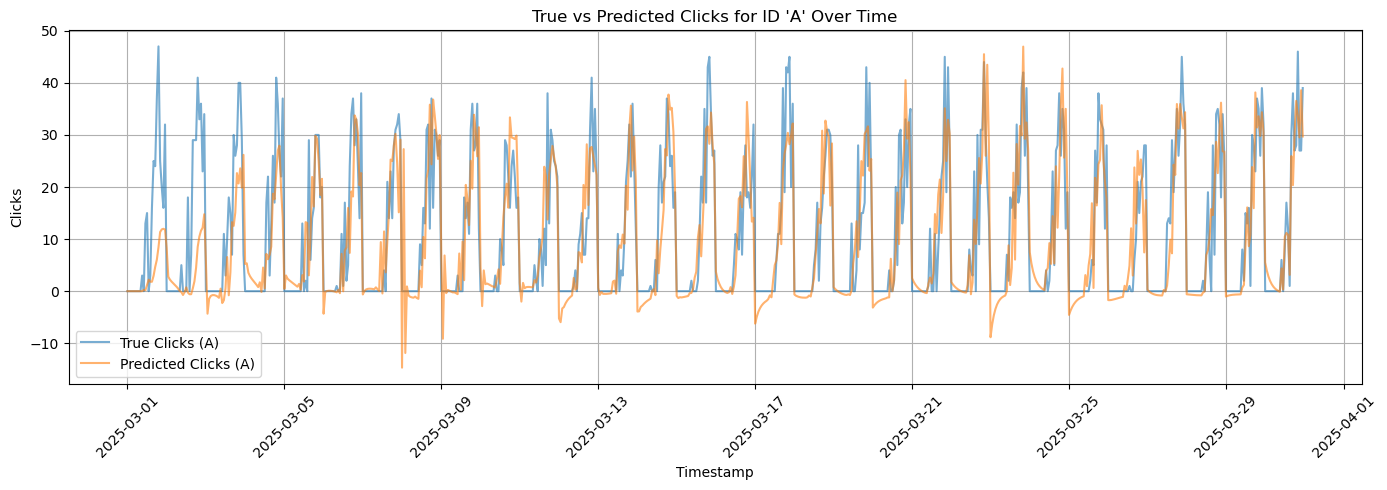

In [46]:
plot_daily('A')

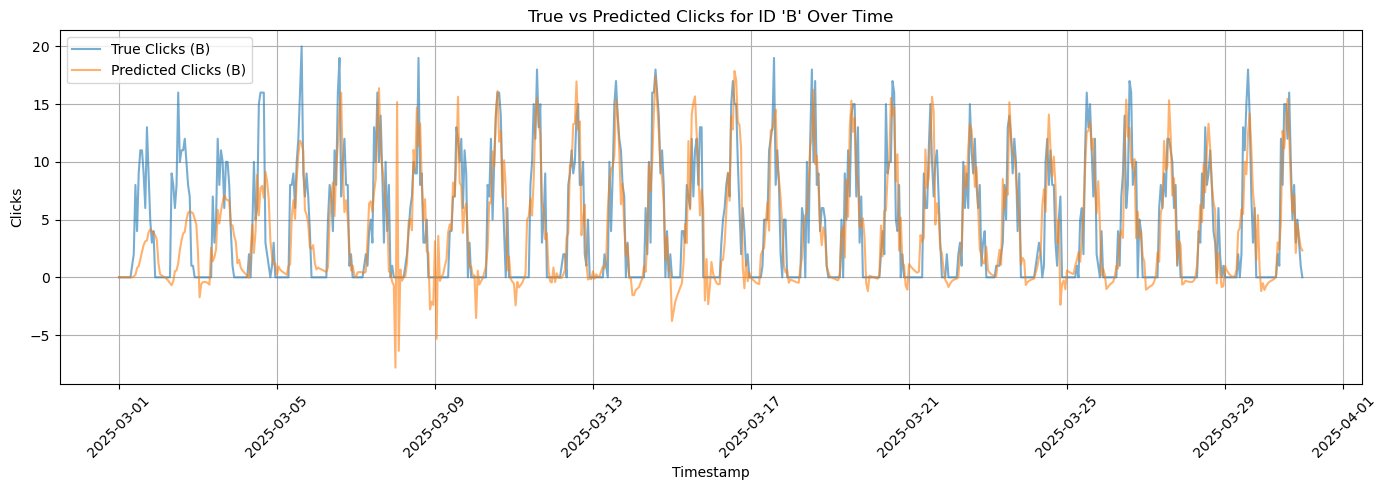

In [48]:
plot_daily('B')

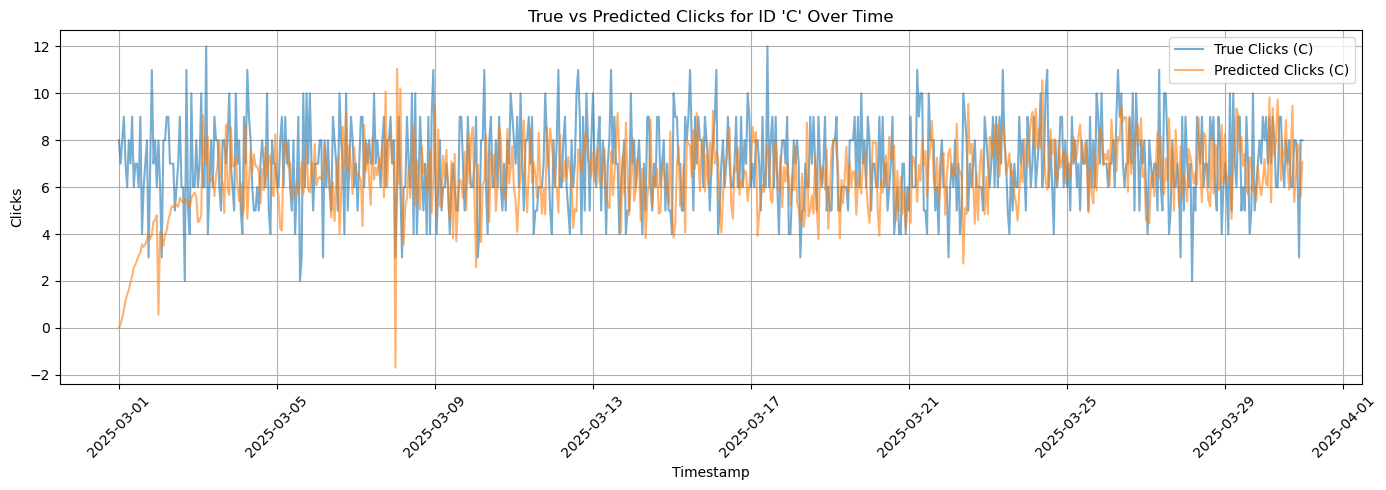

In [50]:
plot_daily('C')

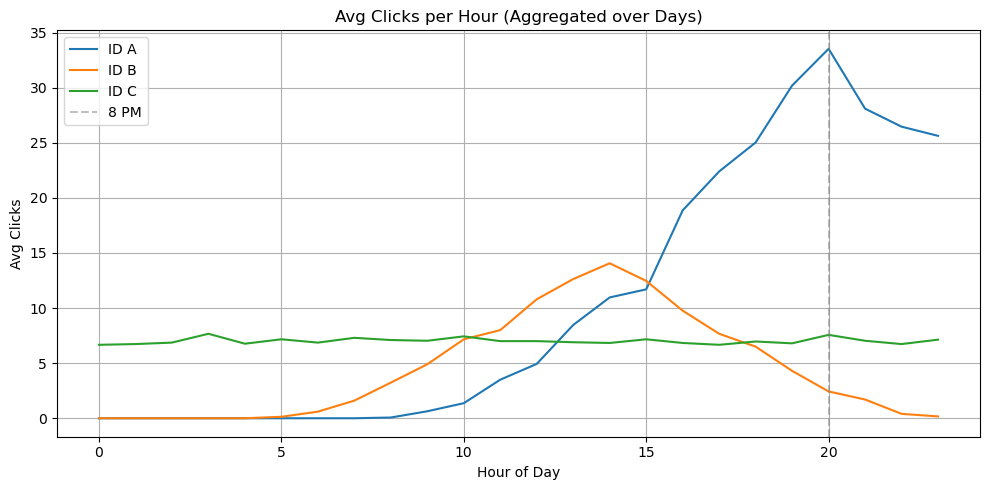

In [52]:
import pandas as pd
from collections import defaultdict

# --- Step 6: Aggregate for plotting ---
hourly_patterns = defaultdict(lambda: defaultdict(list))  # {id: {hour: [clicks]}}

for item_id, ts, y in data:
    hourly_patterns[item_id][ts.hour].append(y)

# Convert to DataFrame for plotting
df = pd.DataFrame({
    item_id: [sum(vals)/len(vals) for hour, vals in sorted(hourly_patterns[item_id].items())]
    for item_id in hourly_patterns
}, index=range(24))

# --- Step 7: Plot hourly pattern for each ID ---
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df.index, df[col], label=f'ID {col}')

plt.axvline(20, color='gray', linestyle='--', alpha=0.5, label='8 PM')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Clicks')
plt.title('Avg Clicks per Hour (Aggregated over Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()